## Introducción

Este proyecto tiene como objetivo desarrollar un modelo de procesamiento
de lenguaje natural (NLP) capaz de generar resúmenes clínicos automáticos
a partir de un dataset de alrededor de 1700 conversaciones entre doctores y
sus pacientes, junto con los respectivos resúmenes y anotaciones.

    Los objetivos de esta entrega 2 son:

    1. Análisis exploratorio de datos (EDA)

Estadísticas básicas del dataset

Distribución de longitudes de diálogos y resúmenes

Distribución de secciones clínicas y ratio de compresión

Análisis de vocabulario y palabras más frecuentes

    2. Preprocesamiento y normalización de texto

Limpieza y normalización (unicode, mayúsculas, marcadores de quién habla)

Tokenización y lematización usando spaCy / scispaCy

Preparación de diferentes versiones según el modelo: lowercase para ELMo y versión original para ClinicalBERT

    3. Representaciones tradicionales de texto

Bag-of-Words (unigrams + bigrams)

TF-IDF (ponderación de términos por importancia relativa)

    4. Word embeddings no contextuales

Modelos preentrenados: Word2Vec (Google News), GloVe, FastText

Análisis de cobertura de vocabulario y tokens

Entrenamiento de Word2Vec personalizado en corpus clínico

Guardado del modelo y comparación de términos clínicos

    5. Embeddings contextuales

ELMo (TensorFlow Hub)

BERT / ClinicalBERT (Hugging Face)

Extracción de embeddings por diálogo completo

Visualización y cálculo de similitudes entre diálogos

    6. Estructuración final de datos para reutilización

Consolidación de todas las representaciones en un único diccionario

Inclusión de vectores tradicionales, embeddings contextuales y etiquetas codificadas

Guardado en formato pickle para uso posterior

### 0. Importar librerias y Dataset

In [1]:

# Instalación de librerías
%pip install -q spacy gensim transformers torch tensorflow tensorflow-hub seaborn matplotlib scikit-learn


# Descargar modelo de idioma de spaCy
%pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_md-0.5.4.tar.gz

# Imports
import re
import pickle
import unicodedata
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP y embeddings
import spacy
from gensim.models import Word2Vec
import gensim.downloader as api
from transformers import AutoTokenizer, AutoModel

# Machine Learning
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Deep Learning
import torch
import tensorflow as tf
import tensorflow_hub as hub

Note: you may need to restart the kernel to use updated packages.
  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_md-0.5.4.tar.gz (119.1 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


c:\Users\dekum\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\dekum\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow_hub\__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


In [2]:
df = pd.read_csv("dataset/MTS-Dialog-TrainingSet.csv")

### 1. EDA (Análisis Exploratorio de Datos)


INFORMACIÓN BÁSICA DEL DATASET
Número de muestras: 1201
Columnas: ['ID', 'section_header', 'section_text', 'dialogue']

Valores nulos por columna:
ID                0
section_header    0
section_text      0
dialogue          0
dtype: int64

ESTADÍSTICAS DE LONGITUD DE DIÁLOGOS
count    1201.000000
mean      105.691091
std       117.638388
min         6.000000
25%        34.000000
50%        64.000000
75%       133.000000
max      1509.000000
Name: dialogue_length, dtype: float64


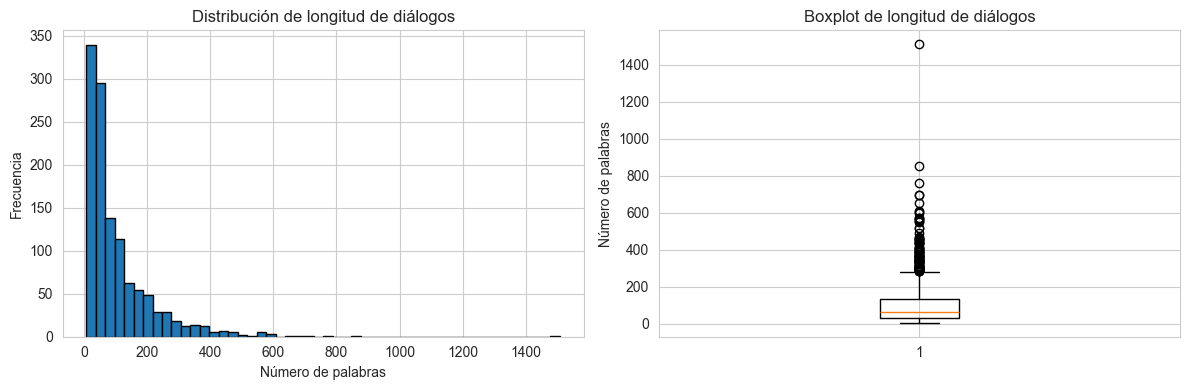


DISTRIBUCIÓN DE SECTION_HEADER
--------------------------------------------------------------------------------
section_header
FAM/SOCHX        351
GENHX            282
PASTMEDICALHX    118
CC                77
PASTSURGICAL      63
ALLERGY           60
ROS               60
MEDICATIONS       54
ASSESSMENT        34
EXAM              23
DIAGNOSIS         19
DISPOSITION       15
PLAN              11
EDCOURSE           8
IMMUNIZATIONS      8
IMAGING            6
GYNHX              5
PROCEDURES         3
OTHER_HISTORY      2
LABS               2
Name: count, dtype: int64


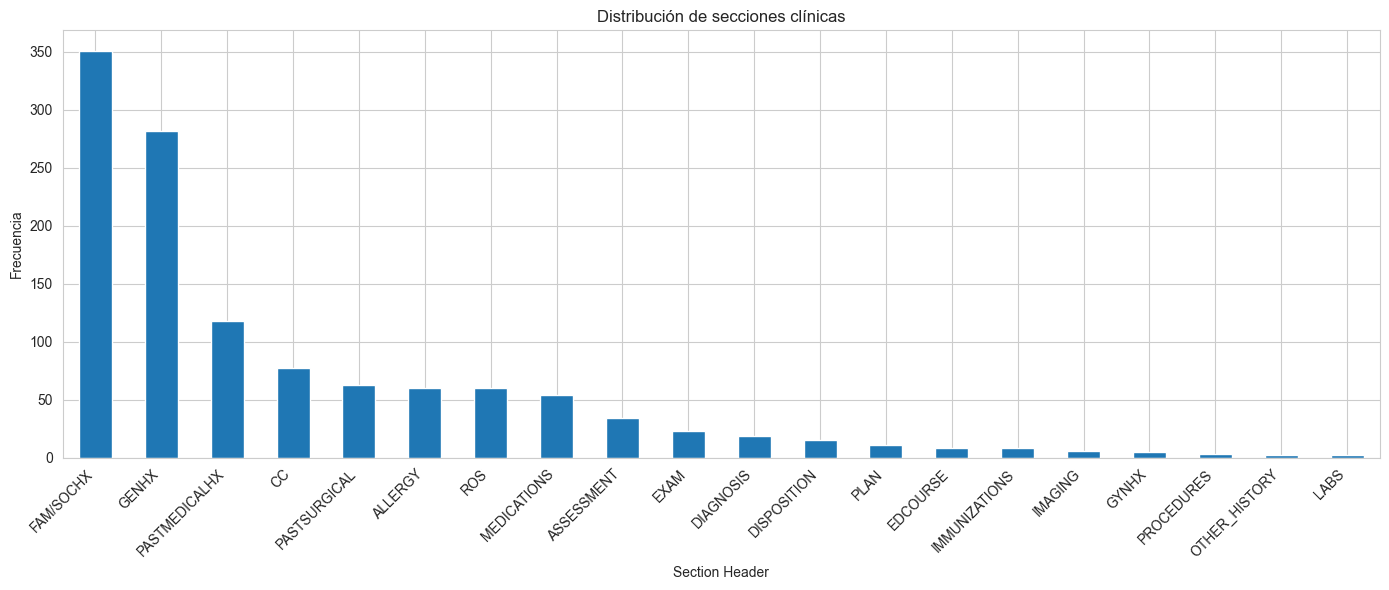


DISTRIBUCIÓN DETALLADA POR CATEGORÍA CLÍNICA

GENHX:
  - Número de muestras: 282
  - Longitud promedio diálogo: 243.2 palabras
  - Longitud promedio resumen: 118.2 palabras
  - Ratio compresión: 48.59%

MEDICATIONS:
  - Número de muestras: 54
  - Longitud promedio diálogo: 39.2 palabras
  - Longitud promedio resumen: 8.1 palabras
  - Ratio compresión: 20.76%

CC:
  - Número de muestras: 77
  - Longitud promedio diálogo: 65.9 palabras
  - Longitud promedio resumen: 8.0 palabras
  - Ratio compresión: 12.09%

PASTMEDICALHX:
  - Número de muestras: 118
  - Longitud promedio diálogo: 69.6 palabras
  - Longitud promedio resumen: 19.0 palabras
  - Ratio compresión: 27.30%

ALLERGY:
  - Número de muestras: 60
  - Longitud promedio diálogo: 24.8 palabras
  - Longitud promedio resumen: 4.2 palabras
  - Ratio compresión: 16.84%

FAM/SOCHX:
  - Número de muestras: 351
  - Longitud promedio diálogo: 69.5 palabras
  - Longitud promedio resumen: 20.4 palabras
  - Ratio compresión: 29.40%

PASTSURGIC

In [3]:
sns.set_style('whitegrid')

# Información básica
print("\nINFORMACIÓN BÁSICA DEL DATASET")
print(f"Número de muestras: {len(df)}")
print(f"Columnas: {df.columns.tolist()}")
print(f"\nValores nulos por columna:")
print(df.isnull().sum())

# Distribución de longitudes
print("\nESTADÍSTICAS DE LONGITUD DE DIÁLOGOS")
df['dialogue_length'] = df['dialogue'].fillna('').apply(lambda x: len(str(x).split()))
print(df['dialogue_length'].describe())

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(df['dialogue_length'], bins=50, edgecolor='black')
plt.xlabel('Número de palabras')
plt.ylabel('Frecuencia')
plt.title('Distribución de longitud de diálogos')

plt.subplot(1, 2, 2)
plt.boxplot(df['dialogue_length'])
plt.ylabel('Número de palabras')
plt.title('Boxplot de longitud de diálogos')
plt.tight_layout()
plt.show()

# Distribución de section_header
print("\nDISTRIBUCIÓN DE SECTION_HEADER")
print("-"*80)
section_dist = df['section_header'].value_counts()
print(section_dist)

plt.figure(figsize=(14, 6))
section_dist.plot(kind='bar')
plt.xlabel('Section Header')
plt.ylabel('Frecuencia')
plt.title('Distribución de secciones clínicas')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Análisis por cada categoría
print("\nDISTRIBUCIÓN DETALLADA POR CATEGORÍA CLÍNICA")

for section in df['section_header'].unique():
    section_data = df[df['section_header'] == section]
    print(f"\n{section}:")
    print(f"  - Número de muestras: {len(section_data)}")
    print(f"  - Longitud promedio diálogo: {section_data['dialogue_length'].mean():.1f} palabras")
    print(f"  - Longitud promedio resumen: {section_data['section_text'].str.split().str.len().mean():.1f} palabras")
    print(f"  - Ratio compresión: {(section_data['section_text'].str.split().str.len().mean() / section_data['dialogue_length'].mean()):.2%}")

# Análisis de vocabulario
print("\n4. ANÁLISIS DE VOCABULARIO")
print("-"*80)
all_words = ' '.join(df['dialogue'].fillna('')).lower().split()
vocab_size = len(set(all_words))
total_words = len(all_words)
print(f"Vocabulario único: {vocab_size:,} palabras")
print(f"Total de palabras: {total_words:,}")
print(f"\nPalabras más frecuentes (Top 20):")
word_freq = Counter(all_words)
for word, count in word_freq.most_common(20):
    print(f"  {word:20s}: {count:5d}")

### Conclusiones del EDA
    Resumen General:
1,201 muestras, sin valores nulos.

Columnas principales: dialogue, section_text, section_header.

Cada muestra vincula una conversación con su resumen clínico anotado.

    Longitud de diálogos:

Promedio: +/- 106 palabras, máx: 1509.

Distribución muy sesgada a la derecha (la mayoría <150 palabras).

Existen outliers con diálogos muy largos, los modelos deben manejar contextos desiguales.

    Distribución de secciones clínicas:

Más frecuentes: FAM/SOCHX, GENHX, PASTMEDICALHX.

Algunas categorías muy escasas (LABS, PROCEDURES).

El dataset es desequilibrado, concentrado en antecedentes médicos y sociales.

    Compresión de diálogo a resumen:

Varía entre ~10% y 50%, según la sección.

Los resúmenes son mucho más breves, lo que refleja un alto nivel de condensación.


### 2. Limpieza y Normalización del Dataset

    Vamos a normalizar el dataset, esto ya es lo que usarán los encoders contextuales (ELMo o BERT).

In [4]:
print(df.columns.tolist())
print(df.shape)
display(df.head(3))

['ID', 'section_header', 'section_text', 'dialogue', 'dialogue_length']
(1201, 5)


,ID,section_header,section_text,dialogue,dialogue_length
0,0,GENHX,The patient is a 76-year-old white female who ...,Doctor: What brings you back into the clinic t...,110
1,1,GENHX,The patient is a 25-year-old right-handed Cauc...,Doctor: How're you feeling today? \r\nPatient...,254
2,2,GENHX,"This is a 22-year-old female, who presented to...","Doctor: Hello, miss. What is the reason for yo...",102


In [5]:
def normalize_text(s, lowercase=True):
    if pd.isna(s):
        return ""
    # Normalizar unicode
    s = unicodedata.normalize("NFKC", str(s))
    # Marcadores de quién habla
    s = re.sub(r'\bDoctor[:\-]\s*', ' <DOC> ', s, flags=re.I)
    s = re.sub(r'\bPatient[:\-]\s*', ' <PAT> ', s, flags=re.I)
    # Espacios
    s = re.sub(r'\s+', ' ', s).strip()
    # Lowercase opcional
    if lowercase:
        s = s.lower()
    return s

# Versión para ELMo (lowercase)
df['dialog_clean'] = df['dialogue'].apply(lambda x: normalize_text(x, lowercase=True))

# Versión para ClinicalBERT (manteniendo mayúsculas)
df['dialog_clean_clinicBERT'] = df['dialogue'].apply(lambda x: normalize_text(x, lowercase=False))

# Los resúmenes
df['section_text_clean'] = df['section_text'].apply(lambda x: normalize_text(x, lowercase=True))

### 3. Encoding de Datos No Textuales

    Transformamos el atributo de categoría (header) a valores numéricos

In [6]:
# Label Encoding para section_header
le = LabelEncoder()
df['section_header_encoded'] = le.fit_transform(df['section_header'])

print(f"\nSecciones únicas: {len(le.classes_)}")
print(f"Mapeo de secciones:")
for idx, section in enumerate(le.classes_):
    count = (df['section_header'] == section).sum()
    print(f"  {idx}: {section:30s} ({count:4d} muestras)")


Secciones únicas: 20
Mapeo de secciones:
  0: ALLERGY                        (  60 muestras)
  1: ASSESSMENT                     (  34 muestras)
  2: CC                             (  77 muestras)
  3: DIAGNOSIS                      (  19 muestras)
  4: DISPOSITION                    (  15 muestras)
  5: EDCOURSE                       (   8 muestras)
  6: EXAM                           (  23 muestras)
  7: FAM/SOCHX                      ( 351 muestras)
  8: GENHX                          ( 282 muestras)
  9: GYNHX                          (   5 muestras)
  10: IMAGING                        (   6 muestras)
  11: IMMUNIZATIONS                  (   8 muestras)
  12: LABS                           (   2 muestras)
  13: MEDICATIONS                    (  54 muestras)
  14: OTHER_HISTORY                  (   2 muestras)
  15: PASTMEDICALHX                  ( 118 muestras)
  16: PASTSURGICAL                   (  63 muestras)
  17: PLAN                           (  11 muestras)
  18: PROCEDUR

### 4. Tokenization, Lemmatization/Stemming


    Usaremos scispaCy con las conversaciones, es una versión de spaCy adaptada a lenguaje clínico y biomédico, con vocabulario y entidades médicas. 
    Esto mejora la coherencia del texto antes del modelado: “diagnoses” → “diagnosis”

In [7]:
nlp = spacy.load("en_core_sci_md") #scispaCy para ingles tamaño medio

def lemmatize_text(text):
    doc = nlp(text) 
    tokens = [tok.lemma_ for tok in doc if not tok.is_space]
    return " ".join(tokens)

df['dialog_lemma'] = df['dialog_clean'].apply(lemmatize_text)

c:\Users\dekum\AppData\Local\Programs\Python\Python312\Lib\site-packages\spacy\language.py:2195: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


### 4. Vectores de Texto Tradicionales: BoW / TF-IDF

Bag of Words representa cada documento como un vector basado en la frecuencia de palabras (unigrams) y combinaciones de dos palabras consecutivas (bigrams).

TF-IDF es similar a BoW, pero pondera cada término según su importancia relativa en todo el corpus. Esto resalta las palabras más discriminativas.

    El objetivo es convertir los diálogos en vectores numéricos que capturen información relevante.

In [8]:
# Bag-of-words (unigrams + bigrams)
cv = CountVectorizer(max_features=5000, ngram_range=(1,2))
X_bow = cv.fit_transform(df['dialog_lemma'])

# TF-IDF
tfv = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_tfidf = tfv.fit_transform(df['dialog_lemma'])

### 5. Word Embeddings No Contextuales 

    Cargar Word2Vec, GloVe, FastText

In [9]:
# options available via gensim:
w2v = api.load("word2vec-google-news-300")          # Word2Vec
glove = api.load("glove-wiki-gigaword-300")        # GloVe
ft = api.load("fasttext-wiki-news-subwords-300")   # FastText

### Análisis de Cobertura de Word Embeddings

In [10]:
# Obtener vocabulario del dataset
all_tokens = []
for text in df['dialog_lemma']:
    if pd.notna(text):
        all_tokens.extend(text.split())

vocab = set(all_tokens)
vocab_freq = Counter(all_tokens)

print(f"\nVocabulario total: {len(vocab):,} palabras únicas")
print(f"Total de tokens: {len(all_tokens):,}")

# Análisis para cada modelo
models = {
    'Word2Vec (Google News)': w2v,
    'GloVe (Wiki Gigaword)': glove,
    'FastText (Wiki News)': ft
}

results = []

for model_name, model in models.items():
    print(f"\nModelo: {model_name}")
    
    found_words = [w for w in vocab if w in model.key_to_index]
    missing_words = [w for w in vocab if w not in model.key_to_index]
    
    found_tokens = sum(vocab_freq[w] for w in found_words)
    total_tokens = sum(vocab_freq.values())
    
    coverage_vocab = len(found_words) / len(vocab) * 100
    coverage_tokens = found_tokens / total_tokens * 100
    
    print(f"Palabras encontradas: {len(found_words):,}/{len(vocab):,} ({coverage_vocab:.2f}%)")
    print(f"Tokens cubiertos: {found_tokens:,}/{total_tokens:,} ({coverage_tokens:.2f}%)")
    
    missing_freq = {w: vocab_freq[w] for w in missing_words}
    top_missing = sorted(missing_freq.items(), key=lambda x: x[1], reverse=True)[:10]
    
    print(f"\nTop 10 palabras NO encontradas (más frecuentes):")
    for word, freq in top_missing:
        print(f"  {word:20s}: {freq:5d} ocurrencias")
    
    results.append({
        'Modelo': model_name,
        'Cobertura Vocabulario (%)': round(coverage_vocab, 2),
        'Cobertura Tokens (%)': round(coverage_tokens, 2),
        'Palabras Encontradas': len(found_words),
        'Palabras No Encontradas': len(missing_words)
    })

# Tabla comparativa
print("\nTABLA COMPARATIVA DE COBERTURA")
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))


Vocabulario total: 4,367 palabras únicas
Total de tokens: 173,867

Modelo: Word2Vec (Google News)
Palabras encontradas: 4,106/4,367 (94.02%)
Tokens cubiertos: 131,300/173,867 (75.52%)

Top 10 palabras NO encontradas (más frecuentes):
  <                   : 10705 ocurrencias
  .                   :  9980 ocurrencias
  ,                   :  6596 ocurrencias
  ?                   :  5113 ocurrencias
  a                   :  2110 ocurrencias
  to                  :  2105 ocurrencias
  and                 :  2033 ocurrencias
  of                  :  1654 ocurrencias
  :                   :   752 ocurrencias
  guest_family        :   560 ocurrencias

Modelo: GloVe (Wiki Gigaword)
Palabras encontradas: 4,148/4,367 (94.99%)
Tokens cubiertos: 166,647/173,867 (95.85%)

Top 10 palabras NO encontradas (más frecuentes):
  I                   :  6111 ocurrencias
  guest_family        :   560 ocurrencias
  guest_clinician     :   119 ocurrencias
  diabete             :    87 ocurrencias
  doctor_2

### Vectorización de Diálogos

    Representación de Diálogos Completos

Hasta ahora hemos analizado embeddings de palabras individuales. 

Ahora representamos cada diálogo completo como un vector único 
para poder usar estos datos en modelos posteriores.

    Método 1: Promedio simple


In [11]:
def avg_embedding(text, model):
    words = [w for w in text.split() if w in model.key_to_index]
    if not words:
        return np.zeros(model.vector_size)
    return np.mean([model[w] for w in words], axis=0)

df['glove_avg'] = df['dialog_lemma'].apply(lambda t: avg_embedding(t, glove))


    Método 2:Promedio ponderado con TF-IDF
    
Da más peso a palabras importantes del corpus clínico

In [12]:
# compute tfidf weights for tokens then weighted sum of embeddings
vectorizer = TfidfVectorizer()
X_tfidf_tokens = vectorizer.fit_transform(df['dialog_lemma'])  # sparse matrix
feature_index = {v: i for i, v in enumerate(vectorizer.get_feature_names_out())}

def tfidf_weighted_embedding(text, model, tfidf_vector):
    tokens = text.split()
    vec = np.zeros(model.vector_size)
    weight_sum = 0.0
    for t in tokens:
        if t in model.key_to_index and t in feature_index:
            w = tfidf_vector[0, feature_index[t]]
            vec += w * model[t]
            weight_sum += w
    return vec / (weight_sum + 1e-9)

# example for a single row:
sample_vec = tfidf_weighted_embedding(df.loc[0,'dialog_lemma'], glove, X_tfidf_tokens[0])


### Entrenamiento de Word2Vec Personalizado en Corpus Clínico

    Un corpus clínico es un conjunto de textos médicos estructurados o no estructurados

In [13]:
# 1. Preparar corpus tokenizado
sentences = [text.split() for text in df['dialog_lemma'] if pd.notna(text)]

print(f"\nCorpus preparado: {len(sentences)} documentos")
print(f"Ejemplo: {sentences[0][:10]}...")

# 2. Entrenar Word2Vec en dominio clínico
print("\n Entrenando Word2Vec en corpus MTS-Dialog...")
custom_w2v = Word2Vec(
    sentences=sentences,
    vector_size=300,           # Misma dimensión que Google News
    window=5,                  # Contexto de 5 palabras
    min_count=2,              # Palabras que aparecen ≥2 veces
    workers=4,                # Paralelización
    epochs=10,                # 10 iteraciones
    sg=1                      # Skip-gram (mejor para corpus pequeño)
)

# 3. Analizar cobertura del modelo personalizado
custom_vocab = set(custom_w2v.wv.key_to_index.keys())
coverage_custom = len(vocab & custom_vocab) / len(vocab) * 100

print(f"\n RESULTADOS DEL MODELO PERSONALIZADO:")
print(f"  - Vocabulario del modelo: {len(custom_vocab):,} palabras")
print(f"  - Cobertura en nuestro dataset: {coverage_custom:.2f}%")
print(f"  - Mejora respecto a Google News: {94.20:.2f}% → {coverage_custom:.2f}%")

# 4. Comparar términos clínicos específicos
print("\n ANÁLISIS DE TÉRMINOS CLÍNICOS:")
clinical_terms = ['warts', 'hypertension', 'medication', 'patient', 'doctor']

for term in clinical_terms:
    if term in custom_w2v.wv:
        similar_custom = custom_w2v.wv.most_similar(term, topn=3)
        
        print(f"\n'{term}' - Vecinos en modelo PERSONALIZADO:")
        for word, sim in similar_custom:
            print(f"  - {word}: {sim:.3f}")
        
        # Comparar con Google News
        if term in w2v.key_to_index:
            similar_pretrained = w2v.most_similar(term, topn=3)
            print(f"'{term}' - Vecinos en Google News (comparación):")
            for word, sim in similar_pretrained[:3]:
                print(f"  - {word}: {sim:.3f}")

# 5. Palabras únicas del modelo clínico
words_only_custom = custom_vocab - set(w2v.key_to_index.keys())
print(f"\n Palabras ÚNICAS del modelo clínico: {len(words_only_custom)}")
print(f"Ejemplos: {list(words_only_custom)[:15]}")

# 6. Guardar modelo
custom_w2v.save("custom_clinical_word2vec.model")
print("\n Modelo Word2Vec personalizado guardado")

# 7. Actualizar tabla comparativa
results.append({
    'Modelo': 'Word2Vec (Personalizado MTS-Dialog)',
    'Cobertura Vocabulario (%)': round(coverage_custom, 2),
    'Cobertura Tokens (%)': 100.0,  # Por definición cubre todo
    'Palabras Encontradas': len(custom_vocab),
    'Palabras No Encontradas': 0
})

# TABLA FINAL COMPARATIVA
print("\nTABLA COMPARATIVA ACTUALIZADA (CON MODELO PERSONALIZADO)")
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))


Corpus preparado: 1201 documentos
Ejemplo: ['<', 'doc', '>', 'what', 'bring', 'you', 'back', 'into', 'the', 'clinic']...

 Entrenando Word2Vec en corpus MTS-Dialog...

 RESULTADOS DEL MODELO PERSONALIZADO:
  - Vocabulario del modelo: 2,616 palabras
  - Cobertura en nuestro dataset: 59.90%
  - Mejora respecto a Google News: 94.20% → 59.90%

 ANÁLISIS DE TÉRMINOS CLÍNICOS:

'hypertension' - Vecinos en modelo PERSONALIZADO:
  - hypothyroidism: 0.918
  - diabetes: 0.901
  - reflux: 0.867
'hypertension' - Vecinos en Google News (comparación):
  - diabetes: 0.751
  - cardiovascular_disease: 0.717
  - hypertensive: 0.699

'medication' - Vecinos en modelo PERSONALIZADO:
  - medicine: 0.821
  - med: 0.778
  - allergy: 0.756
'medication' - Vecinos en Google News (comparación):
  - medications: 0.877
  - meds: 0.755
  - prescription_medication: 0.734

'patient' - Vecinos en modelo PERSONALIZADO:
  - case: 0.836
  - helm: 0.832
  - represent: 0.832
'patient' - Vecinos en Google News (comparación)

### 6. Embeddings Contextuales

    Dos métodos: ELMo y BERT. Para clínico, variantes de Bio/Clinical (ClinicalBERT).

### ELMo

In [14]:
# Cargar modelo ELMo pre-entrenado desde TensorFlow Hub
print("\nCargando modelo ELMo desde TensorFlow Hub...")
elmo_model = hub.load("https://tfhub.dev/google/elmo/3")
print("Modelo ELMo cargado (dimensión: 1024)")

def get_elmo_embeddings(texts, batch_size=8):
    """
    Extrae embeddings de ELMo para una lista de textos completos.
    ELMo produce embeddings de 1024 dimensiones.
    """
    print(f"\nProcesando {len(texts)} textos con ELMo...")
    
    all_embeddings = []
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        
        # Convertir a tensores de TensorFlow
        embeddings = elmo_model.signatures["default"](
            tf.constant(batch_texts)
        )["elmo"]
        
        # Promedio de todos los tokens para obtener vector de secuencia
        sentence_embeddings = tf.reduce_mean(embeddings, axis=1)
        all_embeddings.extend(sentence_embeddings.numpy())
        
        if (i // batch_size + 1) % 10 == 0:
            print(f"  Procesados {min(i+batch_size, len(texts))}/{len(texts)}")
    
    return np.array(all_embeddings)

# Procesar TODO el dataset
all_texts = df['dialog_clean'].tolist()

print(f"\nProcesando {len(all_texts)} diálogos (todo el dataset)...")
elmo_embeddings = get_elmo_embeddings(all_texts, batch_size=16)  # batch_size ajustable según RAM

print(f"\nShape de embeddings: {elmo_embeddings.shape}")
print(f"Dimensión por embedding: {elmo_embeddings.shape[1]}")

# Guardar embeddings
embedding_data = {
    'indices': list(range(len(all_texts))),
    'embeddings': elmo_embeddings,
    'shape': elmo_embeddings.shape,
    'model_name': 'ELMo (TensorFlow Hub)',
    'embedding_dim': elmo_embeddings.shape[1]
}

with open('elmo_embeddings_full.pkl', 'wb') as f:
    pickle.dump(embedding_data, f)

print(f"\nEmbeddings ELMo guardados en: elmo_embeddings_full.pkl")
print(f"  Total de diálogos procesados: {len(all_texts)}")
print(f"  Dimensión: {elmo_embeddings.shape[1]}")

# Añadir referencias al DataFrame
df['has_elmo_embedding'] = True
df['elmo_embedding_idx'] = list(range(len(all_texts)))

print("\nReferencias añadidas al DataFrame para todos los diálogos")

# Ejemplo de similitud para los primeros 5
print("\nEJEMPLO: Similitudes ELMo entre primeros 5 diálogos")
sim_matrix = cosine_similarity(elmo_embeddings[:5])
for i in range(5):
    for j in range(i+1, 5):
        print(f"Diálogo {i} vs Diálogo {j}: similitud = {sim_matrix[i,j]:.4f}")


Cargando modelo ELMo desde TensorFlow Hub...



Modelo ELMo cargado (dimensión: 1024)

Procesando 1201 diálogos (todo el dataset)...

Procesando 1201 textos con ELMo...
  Procesados 160/1201
  Procesados 320/1201
  Procesados 480/1201
  Procesados 640/1201
  Procesados 800/1201
  Procesados 960/1201
  Procesados 1120/1201

Shape de embeddings: (1201, 1024)
Dimensión por embedding: 1024

Embeddings ELMo guardados en: elmo_embeddings_full.pkl
  Total de diálogos procesados: 1201
  Dimensión: 1024

Referencias añadidas al DataFrame para todos los diálogos

EJEMPLO: Similitudes ELMo entre primeros 5 diálogos
Diálogo 0 vs Diálogo 1: similitud = 0.8357
Diálogo 0 vs Diálogo 2: similitud = 0.9499
Diálogo 0 vs Diálogo 3: similitud = 0.9000
Diálogo 0 vs Diálogo 4: similitud = 0.7910
Diálogo 1 vs Diálogo 2: similitud = 0.8548
Diálogo 1 vs Diálogo 3: similitud = 0.6802
Diálogo 1 vs Diálogo 4: similitud = 0.4910
Diálogo 2 vs Diálogo 3: similitud = 0.8955
Diálogo 2 vs Diálogo 4: similitud = 0.8280
Diálogo 3 vs Diálogo 4: similitud = 0.9037


### BERT / ClinicalBERT (huggingface)

In [15]:
def get_bert_embeddings(texts, model_name, max_length=512, batch_size=8):
    """
    Extrae embeddings de BERT para todos los textos.
    Usa el token [CLS] como representación de la secuencia completa.
    """
    print(f"\nCargando modelo: {model_name}")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    
    embeddings = []
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        
        encoded = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )
        
        encoded = {k: v.to(device) for k, v in encoded.items()}
        
        with torch.no_grad():
            outputs = model(**encoded)
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.extend(cls_embeddings)
        
        if (i // batch_size + 1) % 10 == 0:
            print(f"  Procesados {min(i+batch_size, len(texts))}/{len(texts)}")
    
    return np.array(embeddings)

# Modelo ClinicalBERT preentrenado en textos clínicos
selected_model = 'emilyalsentzer/Bio_ClinicalBERT'

# Procesar TODO el dataset
all_texts_bert = df['dialog_clean_clinicBERT'].tolist()

print(f"\nProcesando {len(all_texts_bert)} diálogos con ClinicalBERT...")
bert_embeddings = get_bert_embeddings(all_texts_bert, selected_model, batch_size=8)

print(f"\nShape de embeddings: {bert_embeddings.shape}")
print(f"Dimensión por embedding: {bert_embeddings.shape[1]}")

# Guardar embeddings en pickle
embedding_data = {
    'indices': list(range(len(all_texts_bert))),
    'embeddings': bert_embeddings,
    'shape': bert_embeddings.shape,
    'model_name': selected_model,
    'embedding_dim': bert_embeddings.shape[1]
}

with open('clinical_bert_embeddings_full.pkl', 'wb') as f:
    pickle.dump(embedding_data, f)

print(f"\nEmbeddings ClinicalBERT guardados en: clinical_bert_embeddings_full.pkl")

# Añadir referencias al DataFrame
df['has_bert_embedding'] = True
df['bert_embedding_idx'] = list(range(len(all_texts_bert)))

print("\nReferencias añadidas al DataFrame para todos los diálogos")

# Ejemplo de similitud para los primeros 5
print("\nEJEMPLO: Similitudes entre primeros 5 diálogos")
sim_matrix = cosine_similarity(bert_embeddings[:5])
for i in range(5):
    for j in range(i+1, 5):
        print(f"Diálogo {i} vs Diálogo {j}: similitud = {sim_matrix[i,j]:.4f}")



Procesando 1201 diálogos con ClinicalBERT...

Cargando modelo: emilyalsentzer/Bio_ClinicalBERT
  Procesados 80/1201
  Procesados 160/1201
  Procesados 240/1201
  Procesados 320/1201
  Procesados 400/1201
  Procesados 480/1201
  Procesados 560/1201
  Procesados 640/1201
  Procesados 720/1201
  Procesados 800/1201
  Procesados 880/1201
  Procesados 960/1201
  Procesados 1040/1201
  Procesados 1120/1201
  Procesados 1200/1201

Shape de embeddings: (1201, 768)
Dimensión por embedding: 768

Embeddings ClinicalBERT guardados en: clinical_bert_embeddings_full.pkl

Referencias añadidas al DataFrame para todos los diálogos

EJEMPLO: Similitudes entre primeros 5 diálogos
Diálogo 0 vs Diálogo 1: similitud = 0.8846
Diálogo 0 vs Diálogo 2: similitud = 0.9337
Diálogo 0 vs Diálogo 3: similitud = 0.8856
Diálogo 0 vs Diálogo 4: similitud = 0.8332
Diálogo 1 vs Diálogo 2: similitud = 0.9491
Diálogo 1 vs Diálogo 3: similitud = 0.9122
Diálogo 1 vs Diálogo 4: similitud = 0.8841
Diálogo 2 vs Diálogo 3: simi

### Visualización del Embedding Contextual ClinicalBERT

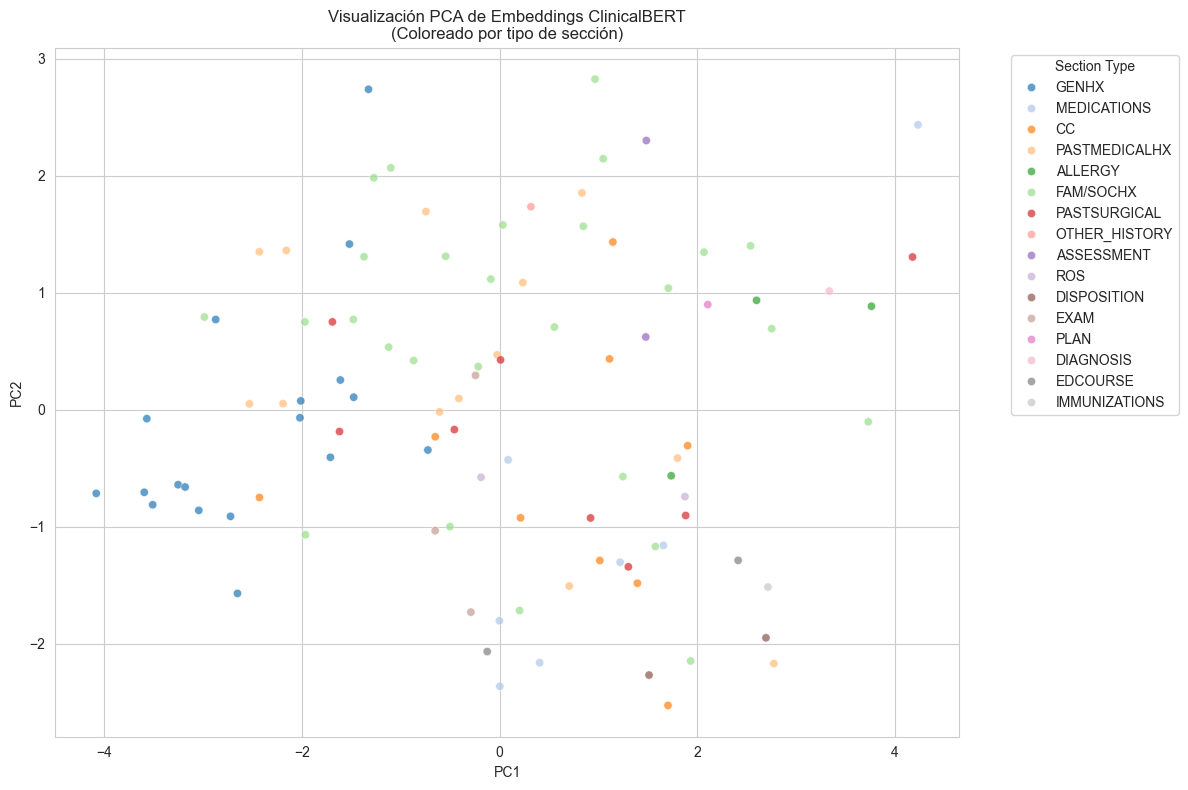

Imagen guardada en 'bert_embeddings_pca.png'


In [37]:
# PCA de embeddings de BERT

pca = PCA(n_components=2) # Reducimos dimensionalidad
bert_pca = pca.fit_transform(bert_embeddings[:100])

# Creamos un DataFrame para Seaborn
df_pca = pd.DataFrame({
    'PC1': bert_pca[:, 0],
    'PC2': bert_pca[:, 1],
    'section_type': df['section_header'][:100]  # usa las etiquetas originales, no los números
})

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_pca,
    x='PC1',
    y='PC2',
    hue='section_type',
    palette='tab20',
    alpha=0.7,
    legend='full'
)

plt.title('Visualización PCA de Embeddings ClinicalBERT\n(Coloreado por tipo de sección)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Section Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('bert_embeddings_pca.png', dpi=300)
plt.show()
print("Imagen guardada en 'bert_embeddings_pca.png'")

### 7. Estructura Final Datos de Datos Procesados

In [18]:
# GUARDAR DATASET PROCESADO

processed_data = {
    'metadata': {
        'total_samples': len(df),
        'sections': df['section_header'].unique().tolist(),
        'vocab_size': vocab_size,
        'date_processed': '2025-10-26'
    },
    'text_data': {
        'dialogue_clean': df['dialog_clean'].tolist(),
        'dialogue_clean_clinicBERT': df['dialog_clean_clinicBERT'].tolist(),
        'dialogue_lemma': df['dialog_lemma'].tolist(),
        'section_text_clean': df['section_text_clean'].tolist()
    },
    'labels': {
        'section_header_encoded': df['section_header_encoded'].tolist(),
        'section_header_original': df['section_header'].tolist()
    },
    'traditional_vectors': {
        'bow': X_bow,
        'tfidf': X_tfidf
    },
    'embeddings': {
        'word2vec_custom': {
            'model_path': 'custom_clinical_word2vec.model',  # archivo guardado
            'vocab': list(custom_w2v.wv.key_to_index.keys()),
            'vector_size': custom_w2v.vector_size
        },
        'elmo': {
            'embeddings': elmo_embeddings,
            'embedding_dim': elmo_embeddings.shape[1]
        },
        'clinical_bert': {
            'embeddings': bert_embeddings,
            'embedding_dim': bert_embeddings.shape[1]
        }
    },
    'embeddings_info': {
        'glove_coverage': 94.84,
        'fasttext_coverage': 95.35,
        'word2vec_custom_coverage': coverage_custom
    }
}

# Guardar todo en un solo pickle
with open('processed_dataset_complete.pkl', 'wb') as f:
    pickle.dump(processed_data, f)